# Large scale text analysis with deep learning

Today we're gonna predict job salary.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download and unpack the data.

You can also get it from [yadisk url](https://yadi.sk/d/vVEOWPFY3NruT7) the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (pick `Train_rev1.*`).

In [2]:
!wget https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
data = pd.read_csv("./Train_rev1.zip", compression='zip', index_col=None)
data.shape

--2023-09-24 09:05:59--  https://ysda-seminars.s3.eu-central-1.amazonaws.com/Train_rev1.zip
Resolving ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)... 52.219.171.214, 3.5.137.167, 52.219.169.6, ...
Connecting to ysda-seminars.s3.eu-central-1.amazonaws.com (ysda-seminars.s3.eu-central-1.amazonaws.com)|52.219.171.214|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128356352 (122M) [application/zip]
Saving to: ‘Train_rev1.zip’

Train_rev1.zip      100%[===================>] 122.41M  28.4MB/s    in 4.5s    

2023-09-24 09:06:04 (27.2 MB/s) - ‘Train_rev1.zip’ saved [128356352/128356352]



(244768, 12)

In [ ]:
data.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


One problem with salary prediction is that it's oddly distributed: there are many people who are paid standard salaries and a few that get tons o money. The distribution is fat-tailed on the right side, which is inconvenient for MSE minimization.

There are several techniques to combat this: using a different loss function, predicting log-target instead of raw target or even replacing targets with their percentiles among all salaries in the training set. We gonna use logarithm for now.

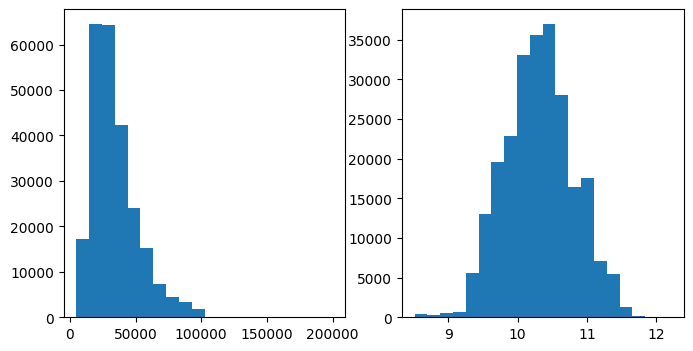

In [3]:
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.hist(data["SalaryNormalized"], bins=20);

plt.subplot(1, 2, 2)
plt.hist(data['Log1pSalary'], bins=20);

Our task is to predict one number, __Log1pSalary__.

To do so, our model can access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.

In [4]:
text_columns = ["Title", "FullDescription"] # где nlp имеет смысл
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
TARGET_COLUMN = "Log1pSalary"

data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast missing values to string "NaN"

data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
14646,66743375,Branch Manager / Domiciliary Care Manager,To apply email CV to Description: As Domicili...,Grantham,Grantham,full_time,NaN,NaN,Consultancy Jobs,"25,000.00 per year + Excellent Uncapped Bonus",25000,Jobcentre Plus,10.126671
228788,72447614,Production Supervisor (FMCG),An exciting opportunity for a couple of Produc...,Surrey South East,Surrey,NaN,permanent,SJS Consulting,Engineering Jobs,"From 23,000 to 26,000 per annum Plus benefits",24500,totaljobs.com,10.106469
198855,71849195,Store Manager Dewsbury,"Store Manager 25k ****k Bonus, Excellent OT...",Dewsbury West Yorkshire Yorkshire,Dewsbury,NaN,permanent,PerfectHome,Accounting & Finance Jobs,25k - 35k per year,30000,totaljobs.com,10.308986


### Preprocessing text data

Just like last week, applying NLP to a problem begins from tokenization: splitting raw text into sequences of tokens (words, punctuation, etc).

Let's lowercase and tokenize all texts under `Title` and `FullDescription` columns. Store the tokenized data as a __space-separated__ string of tokens for performance reasons.

In [5]:
print("Raw text:")
print(data["FullDescription"][2::100000])

Raw text:
2         Mathematical Modeller / Simulation Analyst / O...
100002    A successful and high achieving specialist sch...
200002    Web Designer  HTML, CSS, JavaScript, Photoshop...
Name: FullDescription, dtype: object


In [6]:
import nltk

tokenizer = nltk.tokenize.WordPunctTokenizer()
data['FullDescription'] = data['FullDescription'].apply(lambda item: " ".join(tokenizer.tokenize(item)).lower())

In [7]:
data['Title'] = data['Title'].apply(lambda item: " ".join(tokenizer.tokenize(str(item))).lower())

Now we can assume that our text is a space-separated list of tokens:

In [8]:
print("Tokenized:")
print(data["FullDescription"][2::100000])
assert data["FullDescription"][2][:50] == 'mathematical modeller / simulation analyst / opera'
assert data["Title"][54321] == 'international digital account manager ( german )'

Tokenized:
2         mathematical modeller / simulation analyst / o...
100002    a successful and high achieving specialist sch...
200002    web designer html , css , javascript , photosh...
Name: FullDescription, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times.

Let's count how many times is each word present in the data so that we can build a "white list" of known words.

In [9]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in both "Title" and "FullDescription" in total
for title in data['Title'].values:
  for token in title.split():
    token_counts[token] += 1
for title in data['FullDescription'].values:
  for token in title.split():
    token_counts[token] += 1

In [10]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


In [ ]:
token_counts.most_common(5)

[('and', 2657388),
 ('.', 2523216),
 (',', 2318606),
 ('the', 2080994),
 ('to', 2019884)]

In [ ]:
len(token_counts)

202704

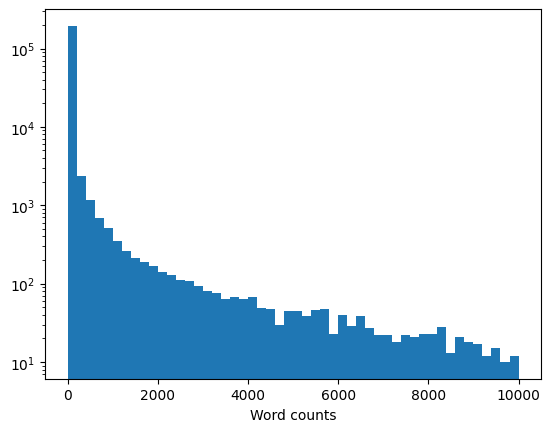

In [ ]:
# Let's see how many words are there for each count
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Закон Ципфа выше видим

Get a list of all tokens that occur at least 10 times.

In [11]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [ ]:
tokens[3]

'$'

In [ ]:
len(tokens)

34158

In [12]:
print("Vocabulary size:", len(tokens))
assert type(tokens) == list
assert len(tokens) in range(32000, 35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Vocabulary size: 34158
Correct!


Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [13]:
token_to_id = dict()
for i in range(len(tokens)):
  token_to_id[tokens[i]] = i

In [14]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into neural network-digestible matrices.

In [15]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))

    max_len = min(max(map(len, sequences)), max_len or float('inf'))

    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix

    return matrix

In [ ]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[10807 30161  2166     1     1]
 [15020  2844     1     1     1]
 [27645 10201    16 15215 10804]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement more advanced encodings: tf-idf, pseudo-time-series, etc.

In [16]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

### The deep learning part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [17]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  195814
Validation size =  48954


In [18]:
import torch
import torch.nn as nn
import torch.functional as F


device = 'cuda' if torch.cuda.is_available() else 'cpu'


def to_tensors(batch, device):
    batch_tensors = dict()
    for key, arr in batch.items():
        if key in ["FullDescription", "Title"]:
            batch_tensors[key] = torch.tensor(arr, device=device, dtype=torch.int64)
        else:
            batch_tensors[key] = torch.tensor(arr, device=device)
    return batch_tensors


def make_batch(data, max_len=None, word_dropout=0, device=device):
    """
    Creates a keras-friendly dict from the batch data.
    :param word_dropout: replaces token index with UNK_IX with this probability
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["FullDescription"] = as_matrix(data["FullDescription"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if word_dropout != 0:
        batch["FullDescription"] = apply_word_dropout(batch["FullDescription"], 1. - word_dropout)

    if TARGET_COLUMN in data.columns:
        batch[TARGET_COLUMN] = data[TARGET_COLUMN].values

    return to_tensors(batch, device)

def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

In [19]:
apply_word_dropout(np.array(make_batch(data_train[:3], max_len=10)['Log1pSalary'].detach().cpu()), 0)

array([0., 0., 0.], dtype=float32)

In [20]:
make_batch(data_train[:3], max_len=10)

{'Title': tensor([[27645, 29893, 33674,     1,     1,     1,     1],
         [29239,   197, 19175, 20042, 15554, 23162,  4051],
         [10609, 30412, 17746,    33,  8705, 29157,    65]], device='cuda:0'),
 'FullDescription': tensor([[27645, 29893, 33674, 32939,   982, 27645, 29893, 33674, 16451, 32939],
         [29239,   197, 19175, 20042, 15554, 23162,  4051, 25511,   907,    82],
         [30746, 21956, 20601,  6409, 16451,  8165, 27493,   982, 30412, 17746]],
        device='cuda:0'),
 'Categorical': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 'Log1pSalary': tensor([ 9.7115, 10.4631, 10.7144], device='cuda:0')}

In [21]:
make_batch(data_train[:3], max_len=10)['Categorical'].shape, make_batch(data_train[:3], max_len=10)['Title'].shape, make_batch(data_train[:3], max_len=10)['FullDescription'].shape

(torch.Size([3, 3768]), torch.Size([3, 7]), torch.Size([3, 10]))

#### Architecture

Our basic model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/nlp_course/raw/master/resources/w2_conv_arch.png)

This clearly doesn't fit into keras' __Sequential__ interface. To build such a network, one will have to use PyTorch.

In [ ]:
emb = torch.nn.Embedding(5, 2)

In [ ]:
emb.weight

Parameter containing:
tensor([[ 0.6957, -1.2996],
        [ 0.0110, -0.3570],
        [ 0.4228,  1.9104],
        [ 1.3488, -0.2397],
        [-0.2609, -2.1580]], requires_grad=True)

In [ ]:
emb(torch.tensor([0,1,2,0,2]))

tensor([[ 0.6957, -1.2996],
        [ 0.0110, -0.3570],
        [ 0.4228,  1.9104],
        [ 0.6957, -1.2996],
        [ 0.4228,  1.9104]], grad_fn=<EmbeddingBackward0>)

In [22]:
DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

device(type='cuda', index=0)

In [23]:
class TextEncoder(nn.Module):
  def __init__(self, n_tokens = len(tokens)):
    super().__init__()
    self.emb = torch.nn.Embedding(n_tokens, 128)
    self.conv1 = torch.nn.Conv1d(128, 128, kernel_size = 3, padding = 'same')
    self.conv2 = torch.nn.Conv1d(128, 256, kernel_size = 5, padding = 'same')
    self.conv3 = torch.nn.Conv1d(256, 256, kernel_size = 5, padding = 'same')
    self.conv4 = torch.nn.Conv1d(256, 128, kernel_size = 3, padding = 'same')
    self.bn256 = torch.nn.BatchNorm1d(256)
    self.bn128 = torch.nn.BatchNorm1d(128)
    self.relu = torch.nn.ReLU()
    self.drop = torch.nn.Dropout(0.2)
    self.mp = torch.nn.MaxPool1d(kernel_size=2, padding=1)
  def forward(self, idx):
    embs = self.emb(idx)
    embs = embs.transpose(2, 1)
    x = self.conv1(embs)
    x = self.bn128(x)
    x = self.relu(x)
    x = self.drop(x)
    x = self.conv2(x)
    x = self.bn256(x)
    x = self.relu(x)
    x = self.drop(x)
    x = self.conv3(x)
    x = self.bn256(x)
    x = self.relu(x)
    x = self.mp(x)
    x = self.drop(x)
    x = self.conv4(x)
    x = self.bn128(x)
    x = self.relu(x)
    return torch.max(x, dim = -1).values

In [24]:
title_enc = TextEncoder()
descr_enc = TextEncoder()
descr_enc.emb = title_enc.emb

In [25]:
title_enc.emb.weight.numel(), title_enc.conv3.weight.numel() # эмбеддинги много занимают

(4372224, 327680)

In [26]:
class CatEncoder(nn.Module):
  def __init__(self, n_cat_features):
    super().__init__()
    self.lin1 = torch.nn.Linear(n_cat_features, 256)
    self.norm256 = torch.nn.BatchNorm1d(256)
    self.norm128 = torch.nn.BatchNorm1d(128)
    self.relu = torch.nn.ReLU()
    self.drop = torch.nn.Dropout(0.1)
    self.lin2 = torch.nn.Linear(256, 256)
    self.lin3 = torch.nn.Linear(256, 128)
    self.lin4 = torch.nn.Linear(128, 128)
  def forward(self, batch):
    batch = self.lin1(batch)
    batch = self.norm256(batch)
    batch = self.relu(batch)
    batch = self.drop(batch)
    batch = self.lin2(batch)
    batch = self.norm256(batch)
    batch = self.relu(batch)
    batch = self.drop(batch)
    batch = self.lin3(batch)
    batch = self.norm128(batch)
    batch = self.relu(batch)
    batch = self.drop(batch)
    batch = self.lin4(batch)
    return batch

In [27]:
class SalaryPredictor(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.title_enc = TextEncoder(n_tokens).to(DEVICE)
        self.descr_enc = TextEncoder(n_tokens).to(DEVICE)
        self.descr_enc.emb = self.title_enc.emb
        self.cat_enc = CatEncoder(n_cat_features).to(DEVICE)
        self.Lin1 = torch.nn.Linear(128 * 3, 256).to(DEVICE)
        self.Relu = nn.ReLU()
        self.Drop = nn.Dropout(0.2)
        self.Lin2 = torch.nn.Linear(256, 1).to(DEVICE)
    def forward(self, batch):
        batch['Title'] = batch['Title'].to(DEVICE)
        batch['FullDescription'] = batch['FullDescription'].to(DEVICE)
        batch['Categorical'] = batch['Categorical'].to(DEVICE)
        batch['Title'] = self.title_enc(batch['Title'])
        batch['FullDescription'] = self.descr_enc(batch['FullDescription'])
        batch['Categorical'] = self.cat_enc(batch['Categorical'])
        x = torch.cat((batch['Title'], batch['FullDescription'], batch['Categorical']), dim=-1)
        x = x.to(DEVICE)
        x = self.Lin1(x)
        x = self.Relu(x)
        x = self.Drop(x)
        return self.Lin2(x).squeeze(1)

In [ ]:
model = SalaryPredictor()
model.to(DEVICE)

SalaryPredictor(
  (title_enc): TextEncoder(
    (emb): Embedding(34158, 128)
    (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
    (conv3): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same)
    (conv4): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
    (bn256): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn128): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (drop): Dropout(p=0.2, inplace=False)
    (mp): MaxPool1d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (descr_enc): TextEncoder(
    (emb): Embedding(34158, 128)
    (conv1): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
    (conv2): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=same)
    (conv3): Conv1d(256, 256, kernel_size=(5,), stride=(1,), padding=same

In [ ]:
model = SalaryPredictor()
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [ ]:
dummy_loss

tensor(103.7577, device='cuda:0', grad_fn=<MseLossBackward0>)

#### Training and evaluation

As usual, we gonna feed our monster with random minibatches of data.

As we train, we want to monitor not only loss function, which is computed in log-space, but also the actual error measured in dollars.

In [28]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, device=device, **kwargs):
    """ iterates minibatches of data in random order """
    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], device=device, **kwargs)
            yield batch

        if not cycle: break

### Model training

We can now fit our model the usual minibatch way. The interesting part is that we train on an infinite stream of minibatches, produced by `iterate_minibatches` function.

In [29]:
from tqdm.auto import tqdm

BATCH_SIZE = 16
EPOCHS = 5

In [30]:
def print_metrics(model, data, batch_size=BATCH_SIZE, name="", device=torch.device('cpu'), **kw):
    squared_error = abs_error = num_samples = 0.0
    model.eval()
    with torch.no_grad():
        for batch in iterate_minibatches(data, batch_size=batch_size, shuffle=False, device=device, **kw):
            batch_pred = model(batch)
            squared_error += torch.sum(torch.square(batch_pred - batch[TARGET_COLUMN]))
            abs_error += torch.sum(torch.abs(batch_pred - batch[TARGET_COLUMN]))
            num_samples += len(batch_pred)
    mse = squared_error.detach().cpu().numpy() / num_samples
    mae = abs_error.detach().cpu().numpy() / num_samples
    print("%s results:" % (name or ""))
    print("Mean square error: %.5f" % mse)
    print("Mean absolute error: %.5f" % mae)
    return mse, mae


In [ ]:
model = SalaryPredictor().to(device)
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 16.33795
Mean absolute error: 4.01860
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 13.70989
Mean absolute error: 3.67564
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 12.01468
Mean absolute error: 3.43626
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 11.18580
Mean absolute error: 3.31329
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 12.11263
Mean absolute error: 3.45007


Это был baseline - энкодеры заголовка и описания просто на сверточных слоях, между которыми вставлены стандартные BN, MaxPool, нелинейность, Dropout, а энкодер категориальных фичей - полносвязная нейросеть. Далее выходы трех энкодеров конкатенируются и все пропускается через голову - полносвязные слои.

### Explaining model predictions

It's usually a good idea to understand how your model works before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

In [31]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    sample = dict(sample)
    sample_col_tokens = [tokens[token_to_id.get(tok, 0)] for tok in sample[col_name].split()]
    data_drop_one_token = pd.DataFrame([sample] * (len(sample_col_tokens) + 1))

    for drop_i in range(len(sample_col_tokens)):
        data_drop_one_token.loc[drop_i, col_name] = ' '.join(UNK if i == drop_i else tok
                                                   for i, tok in enumerate(sample_col_tokens))

    *predictions_drop_one_token, baseline_pred = model(make_batch(data_drop_one_token, device=device)).detach().cpu()
    diffs = baseline_pred - torch.Tensor(predictions_drop_one_token)
    return list(zip(sample_col_tokens, diffs))

In [32]:
from IPython.display import HTML, display_html


def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):

    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(float(weight))), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]

    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]


    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))

    return raw_html


In [ ]:
i = 36605
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

sales specialist iv access and infusion

sales representative medical sales iv access and infusion an opportunity to work for the industry leading manufacturer of iv access and infusion solutions . formally recognised as the number **** company in this market space , our client are an ethical and dynamic organisation absolutely committed to the advancement of innovative technologies . job title : sales specialist iv access and infusion selling : medication delivery solutions selling to : iv teams , infection control , lead intensive care nurse specialists , ward managers territory : east midlands location : east midlands package : basic : **** k **** k , uncapped bonus in addition , full corporate benefits company information hugely ethical and professional global organisation extremely well established in the uk the market leader across all of their core business areas focus on providing cutting edge solutions along with outstanding service and support a business that retain talented personnel by offering a strong platform for career development sales specialist iv access and infusion you must have / be the following at least 2 years medical device sales experience . candidates who have sold disposables / consumables or similar into hospitals would be of particular interest . candidates must have sold into hospitals demonstrable performance and achievements so far personable , adaptable and willing to learn keen and eager to be a success candidates must have a degree or at least be able to show a strong ability to learn role information managing the east midlands region selling across the company ' s range of iv and infusion solutions portfolio selling into lead intensive care nurse specialists , ward managers , iv teams , infection control teams , procurement sales specialist iv access and infusion candidates must be eligible to work and live in the uk . please contact allan waller on **** **** **** or please hit the apply button . this job was originally posted as www . salestarget . co . uk / jobseeking / UNK ****

In [ ]:
i = 12077
tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

cleaning operative

12 . 5 hours per week monday friday 9am 11 . 30am duties to include sweeping , mopping , vacuuming , buffing , cleaning staff toilets and rest room . must be able to read as they will be using UNK which need UNK as per instructions on the containers . sucessfull applicants will be trained on all electrical appliances and UNK of cleaning materials .

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 192449
Salary (gbp): tensor([990.0794])


c net web services agile scrum tdd developer

c . net web services agile scrum tdd developer c . net software developer required for a cambridge software house that just keeps innovating and expanding . they now need a further addition to their technical team of experts . you ' ll be working on ground breaking web based solutions that provide a complete integrated solutions from capture , through to the financial back office . to be considered you ' ll be degree educated and be skilled developing with c . net sql server for web products . comfortable working with likes of web services , mvc . agile / scrum methods and a test driven development environment . essential : c sql web development . desired : asp . net . working in their state of the art office across the full project lifecycle , you will be responsible for the design and development of a range of cutting edge microsoft applications for an impressive portfolio of blue chip clients around the globe . the team is going through massive expansion at the moment and the opportunity to enter the team will offer outstanding career potential and highly lucrative rewards . apply right now for the full job description . please submit your cv for the full job description and web link . all applications in confidence . your cv will not be sent anywhere until you have authorised us . we provide services as an agency and an employment business . this job was originally posted as www . cwjobs . co . uk / jobseeking / c %**** UNK ****

In [ ]:
model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu(), make_batch(data.iloc[i: i+1], device=device)['Log1pSalary']

(tensor([6.8988]), tensor([10.5967], device='cuda:0'))

Вроде сеть что-то выучила, потому что dummy_loss был порядка 100 по mse, а стал около 12, но я тут потыкал - какие-то чересчур маленькие числа она предсказывает - вроде среднее распределения log-зарплаты около 10.5, а тут везде по 7, 6, а то и меньше, надо улучшать

Пробуем чуть-чуть увеличить шаг - вдруг модель у нас сошлась к какому-то локальному минимуму (не будем заново инициализировать модель, оставим ту, которую уже немного обучили)

In [ ]:
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(3):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 7.61751
Mean absolute error: 2.72218
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 5.39370
Mean absolute error: 2.27350
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 4.40189
Mean absolute error: 2.04325


Стало явно лучше, обучение идет быстрее

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 243693
Salary (gbp): tensor([3864.8811])


service engineer

service engineer braintree position for a service engineer , looking for industry leading training , lots of overtime opportunities and excellent progression prospects . here is a role for a service engineer looking to work for a market leading brand in the agricultural industry that offers world class training and development resulting in a great career move . the company are a prestigious brand leader who has built a fantastic reputation within the agricultural industry over **** 0 years providing harvesters and related agricultural machinery . known for their professional expertise and great customer service they are expanding operations due to their success and require new staff to join their renowned brand . the role involves field service of roughly a forty mile radius of the depot , providing full services , repairs and maintenance to harvesters and agricultural machinery . ensuring customers always receive great customer service and the highest quality of work ; you will be entrusted to represent this prominent brand . here is a position for a service engineer with experience of agricultural machinery , plant , hgv or psv servicing that wants a secure role offering excellent training and development the role : service engineer agricultural vehicles machinery including claas harvesters field service **** mile radius service , repair and maintenance **** **** ( ote **** with overtime ) training progression van pension **** 9 hour UNK to friday **** 0 hours average overtime per week saturdays on a rota **** saturdays per month average overtime paid at **** hours ( time and a 1 / 3 ), **** hours plus ( time and a ) and sundays ( double time ) the person : service engineer experience of agricultural machinery / claas or plant , hgv or psv servicing ideally nvq qualified , but will oversee for timeserved candidates driving license wants training and development wants to represent a prestigious brand service engineer , agricultural , claas , jcb , komatsu , UNK , volvo , psv , hgv , fitter , field , harvester , hnd , hnc , mechanical , driving , plant , nvq , timeserved , training , progression , trade , qualified , overtime , john deere this vacancy is being advertised by rise technical recruitment ltd . the services of rise technical recruitment ltd are that of an employment agency . rise technical recruitment ltd regrets to inform that our client can only accept applications from candidates who have a valid legal permit or right to work in the united kingdom . potential candidates who do not have this right or permit , or are pending an application to obtain this right or permit should not apply as your details will not be processed .

In [ ]:
model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu(), make_batch(data.iloc[i: i+1], device=device)['Log1pSalary']

(tensor([8.2599]), tensor([9.8653], device='cuda:0'))

Да и предсказания поближе стали :)

In [ ]:
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    print(f"epoch: {epoch}")
    model.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print_metrics(model, data_val, device=device)

epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 3.75603
Mean absolute error: 1.87795
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 2.55346
Mean absolute error: 1.52488
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 1.64579
Mean absolute error: 1.19072
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.93216
Mean absolute error: 0.84802
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.53616
Mean absolute error: 0.60709
epoch: 5


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.33654
Mean absolute error: 0.46728
epoch: 6


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.29994
Mean absolute error: 0.43978
epoch: 7


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.26947
Mean absolute error: 0.41665
epoch: 8


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.29072
Mean absolute error: 0.43308
epoch: 9


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.29628
Mean absolute error: 0.43732


Уже совсем другое дело, лосс значительно упал. При этом последние эпохи уже не приносят более хороших результатов, то есть с таким шагом мы более менее сошлись. Теперь время улучшать наши результаты!

In [ ]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 239706
Salary (gbp): tensor([22466.0039])


hdu junior sister

job ref vac **** job title hdu junior sister location whalley range , manchester salary up to **** job ref vac **** job title hdu junior sister location whalley range , manchester salary up to **** i am recruiting for a private hospital that is part of a large reputable group of private hospitals . my client offers a comprehensive range of services and facilities including specialist treatment for complex orthopaedic and spinal surgery . my client is one of the few private hospitals in the north west to have a dedicated obesity management team and is accredited as a centre of excellence for breast care and bowel cancer . for patients undergoing complex surgical procedures there is a high dependency unit , managed by specialist nurses . my client are looking for a nurse to join the hdu unit . you will need to have a minimum of 2 years post qualifying experience with experience in either hdu or itu if you would like to apply for this post please call emma at eclypse on **** or email your cv to echadwickeclypserecruitment . co . uk

In [ ]:
model(make_batch(data.iloc[i: i+1], device=device)).detach().cpu(), make_batch(data.iloc[i: i+1], device=device)['Log1pSalary']

(tensor([10.0198]), tensor([10.2310], device='cuda:0'))

Не исключено, что тренировка эмбеддингов с нуля - вещь тяжелая и мешающая обучению всей сети в целом, поэтому пробуем подгрузить предобученные

In [47]:
!wget -O glove.zip https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip

--2023-09-24 09:16:33--  https://huggingface.co/stanfordnlp/glove/resolve/main/glove.840B.300d.zip
Resolving huggingface.co (huggingface.co)... 18.172.134.124, 18.172.134.24, 18.172.134.4, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/stanfordnlp/glove/f47355dd5b267bd10f08671e513790690233c76a9ffd73aa915d78f894a8912e?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27glove.840B.300d.zip%3B+filename%3D%22glove.840B.300d.zip%22%3B&response-content-type=application%2Fzip&Expires=1695806194&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5NTgwNjE5NH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9zdGFuZm9yZG5scC9nbG92ZS9mNDczNTVkZDViMjY3YmQxMGYwODY3MWU1MTM3OTA2OTAyMzNjNzZhOWZmZDczYWE5MTVkNzhmODk0YTg5MTJlP3Jlc3BvbnNlLWNvbnRlbnQtZGlzcG9zaXRpb249KiZyZXNwb25zZS1jb250ZW50LXR5cGU9KiJ9XX0_&Signature=MMH

In [48]:
!ls -sh

total 2.3G
113M glove.6B.zip  2.1G glove.zip  4.0K sample_data  123M Train_rev1.zip


In [49]:
!unzip glove.zip

Archive:  glove.zip
  inflating: glove.840B.300d.txt     


In [59]:
from tqdm import tqdm as tqdm_

np.random.seed(19)

# Открываем glove
def load_glove_weights(file_path, vocab):
    print("Loading Glove Weights")
    # Инициализируем веса для всех слов стандартным нормальным распределением
    glove_weights = np.random.uniform(0, 1, (len(vocab), 300))
    mask_found = np.zeros(len(vocab), dtype=bool)

    with open(file_path, 'r') as f:
        for line in tqdm_(f, total=2196018):
            line = line.split()
            token = ' '.join(line[:-300])
            embed = line[-300:]

            if token in vocab:
                ind = vocab[token]
                mask_found[ind] = True
                glove_weights[ind, :] = np.array(list(map(float, embed)), dtype=np.double)

    print(f"{mask_found.sum()} words from vocab of size {len(vocab)} loaded!")

    glove_weights[vocab['PAD']] = np.zeros(300, dtype=np.double)
    return glove_weights, mask_found


glove_weights, mask_found = load_glove_weights('glove.840B.300d.txt', token_to_id)

Loading Glove Weights


100%|██████████| 2196018/2196018 [00:59<00:00, 37082.89it/s]

27514 words from vocab of size 34158 loaded!


Итак, инициализируем эмбеддинги весами glove, при этом не фризим их, чтобы можно было зафайнтюнить. У такого glove размер эмбеддингов 300, поэтому все равно надо немного менять логику сети, поэтому я немного увеличил количество сверточных слоев и добавил больше пуллингов

In [79]:
class TextEncoder1(nn.Module):
  def __init__(self, n_tokens = len(tokens), use_glove = True, freeze_glove = False):
    super().__init__()
    self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=300)
    if use_glove is True:
      self.emb.weight = nn.Parameter(
            torch.tensor(glove_weights, dtype = torch.float),
            requires_grad = (not freeze_glove),
      )

    self.conv1 = torch.nn.Conv1d(300, 256, kernel_size = 3, padding = 'same')
    self.conv2 = torch.nn.Conv1d(256, 256, kernel_size = 5, padding = 'same')
    self.conv3 = torch.nn.Conv1d(256, 512, kernel_size = 5, padding = 'same')
    self.conv4 = torch.nn.Conv1d(512, 512, kernel_size = 5, padding = 'same')
    self.conv5 = torch.nn.Conv1d(512, 256, kernel_size = 5, padding = 'same')
    self.conv6 = torch.nn.Conv1d(256, 128, kernel_size = 3, padding = 'same')
    self.bn256 = torch.nn.BatchNorm1d(256)
    self.bn512 = torch.nn.BatchNorm1d(512)
    self.bn128 = torch.nn.BatchNorm1d(128)
    self.relu = torch.nn.ReLU()
    self.drop = torch.nn.Dropout(0.2)
    self.mp = torch.nn.MaxPool1d(kernel_size=2, padding=1)
  def forward(self, idx):
    embs = self.emb(idx)
    embs = embs.transpose(2, 1)
    x = self.conv1(embs)
    x = self.bn256(x)
    x = self.relu(x)
    x = self.mp(x)
    x = self.drop(x)
    x = self.conv2(x)
    x = self.bn256(x)
    x = self.relu(x)
    x = self.drop(x)
    x = self.conv3(x)
    x = self.bn512(x)
    x = self.relu(x)
    x = self.mp(x)
    x = self.drop(x)
    x = self.conv4(x)
    x = self.bn512(x)
    x = self.relu(x)
    x = self.drop(x)
    x = self.conv5(x)
    x = self.bn256(x)
    x = self.relu(x)
    x = self.mp(x)
    x = self.drop(x)
    x = self.conv6(x)
    x = self.bn128(x)
    x = self.relu(x)
    return torch.max(x, dim = -1).values

class CatEncoder1(nn.Module):
  def __init__(self, n_cat_features):
    super().__init__()
    self.lin1 = torch.nn.Linear(n_cat_features, 256)
    self.norm256 = torch.nn.BatchNorm1d(256)
    self.norm128 = torch.nn.BatchNorm1d(128)
    self.relu = torch.nn.ReLU()
    self.drop = torch.nn.Dropout(0.1)
    self.lin2 = torch.nn.Linear(256, 256)
    self.lin3 = torch.nn.Linear(256, 128)
    self.lin4 = torch.nn.Linear(128, 128)
  def forward(self, batch):
    batch = self.lin1(batch)
    batch = self.norm256(batch)
    batch = self.relu(batch)
    batch = self.drop(batch)
    batch = self.lin2(batch)
    batch = self.norm256(batch)
    batch = self.relu(batch)
    batch = self.drop(batch)
    batch = self.lin3(batch)
    batch = self.norm128(batch)
    batch = self.relu(batch)
    batch = self.drop(batch)
    batch = self.lin4(batch)
    return batch

class SalaryPredictor1(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.title_enc = TextEncoder1(n_tokens).to(DEVICE)
        self.descr_enc = TextEncoder1(n_tokens).to(DEVICE)
        self.descr_enc.emb = self.title_enc.emb
        self.cat_enc = CatEncoder1(n_cat_features).to(DEVICE)
        self.Lin1 = torch.nn.Linear(128 * 3, 256).to(DEVICE)
        self.Relu = nn.ReLU()
        self.Drop = nn.Dropout(0.2)
        self.Lin2 = torch.nn.Linear(256, 1).to(DEVICE)
    def forward(self, batch):
        batch['Title'] = batch['Title'].to(DEVICE)
        batch['FullDescription'] = batch['FullDescription'].to(DEVICE)
        batch['Categorical'] = batch['Categorical'].to(DEVICE)
        batch['Title'] = self.title_enc(batch['Title'])
        batch['FullDescription'] = self.descr_enc(batch['FullDescription'])
        batch['Categorical'] = self.cat_enc(batch['Categorical'])
        x = torch.cat((batch['Title'], batch['FullDescription'], batch['Categorical']), dim=-1)
        x = x.to(DEVICE)
        x = self.Lin1(x)
        x = self.Relu(x)
        x = self.Drop(x)
        return self.Lin2(x).squeeze(1)

model1 = SalaryPredictor1()
model1.to(DEVICE)
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model1(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [80]:
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-3)
EPOCHS = 10
mses = []
maes = []

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model1.train()
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model1(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mse, mae = print_metrics(model1, data_val, device=device)
    mses.append(mse)
    maes.append(mae)

epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 1.48157
Mean absolute error: 1.13110
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.73742
Mean absolute error: 0.73811
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.32234
Mean absolute error: 0.45701
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.26862
Mean absolute error: 0.41479
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.26060
Mean absolute error: 0.40844
epoch: 5


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.26256
Mean absolute error: 0.41029
epoch: 6


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.30411
Mean absolute error: 0.44248
epoch: 7


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.27731
Mean absolute error: 0.42221
epoch: 8


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.25739
Mean absolute error: 0.40692
epoch: 9


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.24698
Mean absolute error: 0.39903


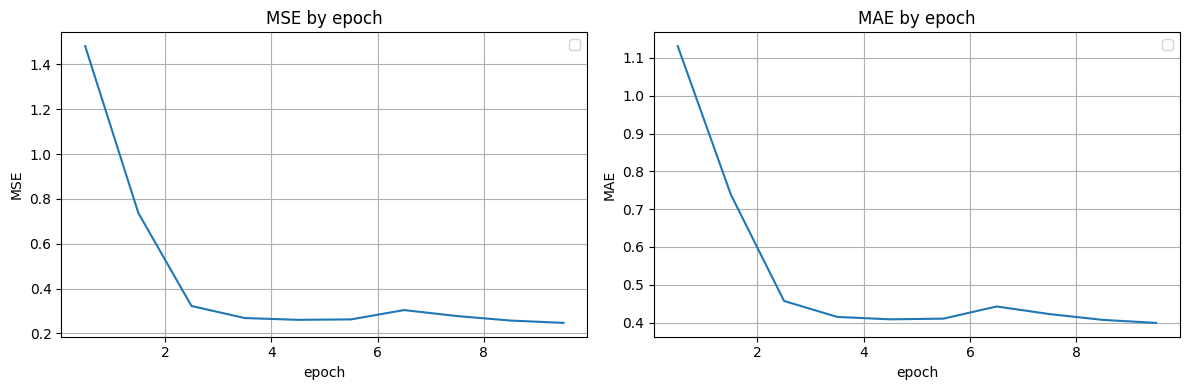

In [81]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)
ax1.set_title('MSE by epoch')
ax1.plot(np.arange(0, len(mses)) + 0.5, mses)
ax1.legend()
ax1.grid()
ax1.set_xlabel('epoch')
ax1.set_ylabel('MSE')

ax2 = plt.subplot(122)
ax2.set_title('MAE by epoch')
ax2.plot(np.arange(0, len(maes)) + 0.5, maes)
ax2.legend()
ax2.grid()
ax2.set_xlabel('epoch')
ax2.set_ylabel('MAE')

fig.tight_layout()
plt.show()

Количество параметров увеличилось, поэтому сетка подольше учится, при этом видны некоторые улучшения - все-таки инициализировать эмбеддинги предобученными дает свои плоды, так как они были обучены "на всем интернете" и, получается, как будто информация со всего интернета отчасти есть в нашей сетке. Видно, что с постоянным шагом, мы упираемся в некий порог, который не можем переступить, в этом нам поможет шедулер. Также мы быстрее дошли до хорошего результата, но скорее благодаря тому, что часть весов уже были хорошие (преобученные эмбеддинги)

In [82]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model1(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model1, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model1, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 199478
Salary (gbp): tensor([26812.3281])


sales executive / sales consultant

bon accord life are seeking talented salespeople to sell a range of protection products on behalf of the uk ’ s biggest life insurance providers . based from our stirling town centre office , a competitive base salary and highly geared commission package will allow earnings of **** k ote ( uncapped ) and top performers can earn much more . package : competitive base salary , ote **** k ( uncapped ) with potential to earn significantly more , excellent career progression prospects within fast growing company . brief job description : professional telephone sales role working for scotland ’ s leading life insurance broker . full training in all products including life insurance , private health insurance and buildings and contents insurance will be provided . sales executive / sales consultant the role you will be provided with around **** new customer leads per month through our website enquiries or interested customers passed directly though to you . completing client fact finds and offering life insurance and protection solutions to your uk client base . sourcing competitive and comprehensive cover from the uk ' s largest insurance providers . identifying cross sell opportunities from your existing and growing client base . sales executive / sales consultant you will have excellent communications skills . have a strong determination to succeed . will be results orientated and be UNK on achieving goals and continuously measure your performance in comparison to your goals . confident on the phone and possess the ability to take control . have proven sales experience and / or be a graduate ( or equivalent ) looking to move into sales . specific telesales experience would be extremely beneficial . this job was originally posted as www . totaljobs . com / jobseeking / UNK ****

In [83]:
model1(make_batch(data.iloc[i: i+1], device=device)).detach().cpu(), make_batch(data.iloc[i: i+1], device=device)['Log1pSalary']

(tensor([10.1967]), tensor([10.3090], device='cuda:0'))

Ну и последнее, что хотелось бы сделать - применить LSTM или GRU, то есть рекуррентную нейросеть. Еще добавим шедулер и early stopping, чтобы все по красоте было



In [84]:
class TextEncoder2(nn.Module):
  def __init__(self, n_tokens = len(tokens), hid_size = 128, use_glove = True, freeze_glove = False,
               bidirectional = True, rnn_type = nn.GRU, reduce = 'mean', num_layers = 5, dropout_p = 0.3):
    super().__init__()
    self.emb = nn.Embedding(num_embeddings=n_tokens, embedding_dim=300)
    if use_glove is True:
      self.emb.weight = nn.Parameter(
            torch.tensor(glove_weights, dtype = torch.float),
            requires_grad = (not freeze_glove),
      )

    self.rnn_type = rnn_type
    D = 2 if bidirectional else 1
    self.reduce = reduce

    rnn_types = [nn.RNN, nn.LSTM, nn.GRU]
    if rnn_type not in rnn_types:
      raise ValueError(f'rnn_cell should be one of {rnn_types}')

    reduce_ways = ['last', 'max', 'mean', 'sum']
    assert reduce in reduce_ways, print(f'reduce must be one of {reduce_ways}')

    self.rnn_layers = rnn_type(
            input_size=300,
            hidden_size=hid_size,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout=dropout_p,
            batch_first=True,
        )

    self.to_features = nn.Linear(hid_size * D, 128)

  def forward(self, texts):
    # texts ~ batch_size x seq_len
    texts = self.emb(texts)
    # embed ~ batch_size x seq_len x embed_size

    if self.rnn_type == nn.LSTM:
        output, (hn, cn) = self.rnn_layers(texts)
    else:
        output, hn = self.rnn_layers(texts)

    # output ~ batch_size x seq_len x hidden_size * 2
    # reduce чтобы уйти от seq_len

    if self.reduce == 'last':
        output = output[:, -1, :]
    elif self.reduce == 'mean':
        output = output.mean(1) # вдоль dim = 1
    elif self.reduce == 'max':
        output = output.max(1)
    elif self.reduce == 'sum':
        output = output.sum(1)

    return self.to_features(output)

class CatEncoder2(nn.Module):
  def __init__(self, n_cat_features):
    super().__init__()
    self.lin1 = torch.nn.Linear(n_cat_features, 256)
    self.norm256 = torch.nn.BatchNorm1d(256)
    self.norm128 = torch.nn.BatchNorm1d(128)
    self.relu = torch.nn.ReLU()
    self.drop = torch.nn.Dropout(0.1)
    self.lin2 = torch.nn.Linear(256, 256)
    self.lin3 = torch.nn.Linear(256, 128)
    self.lin4 = torch.nn.Linear(128, 128)
  def forward(self, batch):
    batch = self.lin1(batch)
    batch = self.norm256(batch)
    batch = self.relu(batch)
    batch = self.drop(batch)
    batch = self.lin2(batch)
    batch = self.norm256(batch)
    batch = self.relu(batch)
    batch = self.drop(batch)
    batch = self.lin3(batch)
    batch = self.norm128(batch)
    batch = self.relu(batch)
    batch = self.drop(batch)
    batch = self.lin4(batch)
    return batch

class SalaryPredictor2(nn.Module):
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):
        super().__init__()
        self.title_enc = TextEncoder2(n_tokens, hid_size).to(DEVICE)
        self.descr_enc = TextEncoder2(n_tokens, hid_size).to(DEVICE)
        self.descr_enc.emb = self.title_enc.emb
        self.cat_enc = CatEncoder2(n_cat_features).to(DEVICE)
        self.Lin1 = torch.nn.Linear(128 * 3, 256).to(DEVICE)
        self.Relu = nn.ReLU()
        self.Drop = nn.Dropout(0.2)
        self.Lin2 = torch.nn.Linear(256, 1).to(DEVICE)
    def forward(self, batch):
        batch['Title'] = batch['Title'].to(DEVICE)
        batch['FullDescription'] = batch['FullDescription'].to(DEVICE)
        batch['Categorical'] = batch['Categorical'].to(DEVICE)
        batch['Title'] = self.title_enc(batch['Title'])
        batch['FullDescription'] = self.descr_enc(batch['FullDescription'])
        batch['Categorical'] = self.cat_enc(batch['Categorical'])
        x = torch.cat((batch['Title'], batch['FullDescription'], batch['Categorical']), dim=-1)
        x = x.to(DEVICE)
        x = self.Lin1(x)
        x = self.Relu(x)
        x = self.Drop(x)
        return self.Lin2(x).squeeze(1)

model2 = SalaryPredictor2()
model2.to(DEVICE)
batch = make_batch(data_train[:100])
criterion = nn.MSELoss()

dummy_pred = model2(batch)
dummy_loss = criterion(dummy_pred, batch[TARGET_COLUMN])
assert dummy_pred.shape == torch.Size([100])
assert len(torch.unique(dummy_pred)) > 20, "model returns suspiciously few unique outputs. Check your initialization"
assert dummy_loss.ndim == 0 and 0. <= dummy_loss <= 250., "make sure you minimize MSE"

In [85]:
criterion = nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.25,
    patience=2,
    threshold=0.05,
    verbose=True
)
min_lr = 4e-6
EPOCHS = 12
mses1 = []
maes1 = []
mses1_train = []

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

for epoch in range(EPOCHS):
    print(f"epoch: {epoch}")
    model2.train()
    losses = []
    for i, batch in tqdm(enumerate(
            iterate_minibatches(data_train, batch_size=BATCH_SIZE, device=device)),
            total=len(data_train) // BATCH_SIZE
        ):
        pred = model2(batch)
        loss = criterion(pred, batch[TARGET_COLUMN])
        losses.append(loss.detach().cpu())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    mses1_train.append(np.array(losses).mean())

    mse, mae = print_metrics(model2, data_val, device=device)
    if scheduler:
      scheduler.step(mse)
    mses1.append(mse)
    maes1.append(mae)

    if min_lr and get_lr(optimizer) <= min_lr:
      print(f'Learning process ended with early stop after epoch {epoch}')
      break

epoch: 0


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.09983
Mean absolute error: 0.23372
epoch: 1


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.07221
Mean absolute error: 0.19866
epoch: 2


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.09059
Mean absolute error: 0.22877
epoch: 3


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.06636
Mean absolute error: 0.19179
epoch: 4


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.06014
Mean absolute error: 0.17813
epoch: 5


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.05723
Mean absolute error: 0.17169
epoch: 6


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.05576
Mean absolute error: 0.17163
epoch: 7


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.06260
Mean absolute error: 0.18269
epoch: 8


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.05264
Mean absolute error: 0.16305
epoch: 9


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.05523
Mean absolute error: 0.16743
epoch: 10


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.06644
Mean absolute error: 0.18871
epoch: 11


  0%|          | 0/12238 [00:00<?, ?it/s]

 results:
Mean square error: 0.05046
Mean absolute error: 0.15675
Epoch 00012: reducing learning rate of group 0 to 2.5000e-04.


Рекуррентные сети дали наилучший результат, что довольно закономерно. Лучше и быстрее всего сошлись, при этом были применены еще трюки с шедулером, который позволил сойтись лучше

In [86]:
get_lr(optimizer)

0.00025

Длина шага уменьшилась

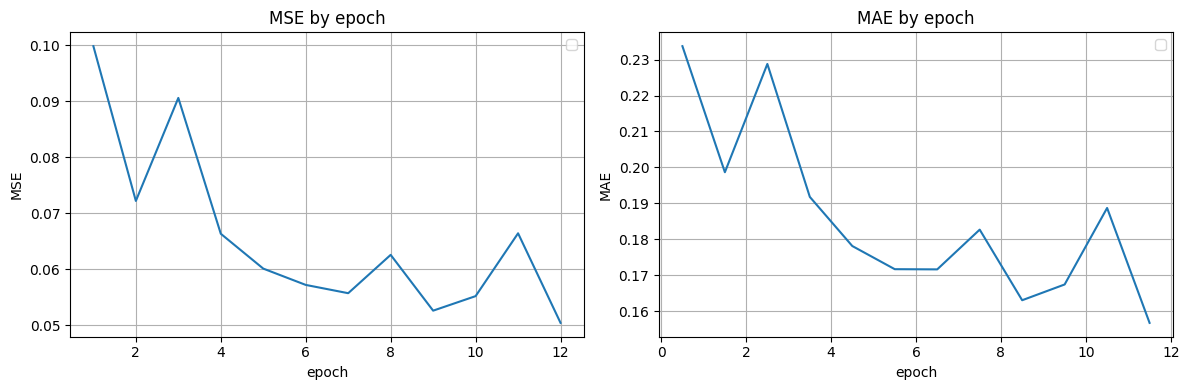

In [88]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)
ax1.set_title('MSE by epoch')
ax1.plot(np.arange(0, len(mses1)) + 1, mses1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('epoch')
ax1.set_ylabel('MSE')

ax2 = plt.subplot(122)
ax2.set_title('MAE by epoch')
ax2.plot(np.arange(0, len(maes1)) + 0.5, maes1)
ax2.legend()
ax2.grid()
ax2.set_xlabel('epoch')
ax2.set_ylabel('MAE')

fig.tight_layout()
plt.show()

In [89]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model2(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model2, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model2, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 193334
Salary (gbp): tensor([27746.4668])


door to door marketing

new marketing opportunity . if you wish to start a new career in january / february with real prospects for the future in a forward thinking , young dynamic renewable energy company , this opportunity is for you . you should be bright , outgoing and enjoy communicating with new people daily . you will be confident , articulate hate to be stuck in an office all day . meeting new challenges every day you will wish to earn between **** **** per week . our full training programme will show you how . transport is provided , training is provided , you need to provide the talent to apply for this new position please contact our local manager **** **** immediate starts available for the right people . self employed people are responsible for paying their own tax national insurance contributions . for information on how this may affect benefits , speak to a UNK plus advisor .

О, тут прокрасы слов хорошо видны)

In [90]:
model2(make_batch(data.iloc[i: i+1], device=device)).detach().cpu(), make_batch(data.iloc[i: i+1], device=device)['Log1pSalary']

(tensor([10.2309]), tensor([9.8114], device='cuda:0'))

In [94]:
i = np.random.randint(len(data))
print("Index:", i)
print("Salary (gbp):", np.expm1(model2(make_batch(data.iloc[i: i+1], device=device)).detach().cpu()))

tokens_and_weights = explain(model2, data.loc[i], "Title")
draw_html([(tok, weight * 5) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model2, data.loc[i], "FullDescription")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights]);

Index: 48242
Salary (gbp): tensor([30887.5977])


creative brand manager

this niche luxury clothing brand is recruiting for a talented marketer to specialise in the creative elements of marketing and take responsibility for the development of print and brand communications , all of which are currently outsourced so this is a fantastic opportunity to establish this new role . currently working for either an agency or inhouse retail marketing department you will have a varied portfolio in digital and print from multichannel to pos , with **** 3 years experience you will have a passion for design , typography and creative thinking an eye for layout and attention to details understanding of the print process and artworking print ready files clear understanding of user experience and usability a professional attitude with the ability to work well within a team and on your own expert skills in photoshop , illustrator and indesign your portfolio should demonstrate a high level of craft as well as the ability to think through the design process from a creative and commercial point of view . last , but not least , you will be passionate about what you do and ready to hit the ground running within a small and highly focused retail team fashion and retail personnel is acting as an employment agency in relation to this vacancy .

In [95]:
model2(make_batch(data.iloc[i: i+1], device=device)).detach().cpu(), make_batch(data.iloc[i: i+1], device=device)['Log1pSalary']

(tensor([10.3381]), tensor([10.2220], device='cuda:0'))

__Terrible start-up idea #1962:__ make a tool that automaticaly rephrases your job description (or CV) to meet salary expectations :)